# Using both regression and machine learning models to predict employee churn.

In this [dataset](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv), there are 14,999 rows, 10 columns, and these variables: 

Variable  |Description |
-----|-----| 
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

In [1]:
# For data manipulation
# For data visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option("display.max_columns", None)

# For saving models
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

# For data modeling
from xgboost import XGBClassifier, XGBRegressor, plot_importance

In [2]:
df = pd.read_csv("HR_comma_sep.csv")
df.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
# standardize dataframe column names
df = df.rename(
    columns={
        "Work_accident": "work_accident",
        "average_montly_hours": "average_monthly_hours",
        "time_spend_company": "tenure",
        "Department": "department",
    }
)
df.head(10)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


In [5]:
df.isna().sum()
# no null entries in dataframe

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [6]:
df.duplicated().sum()
# 3008 duplicate rows
df[df.duplicated()].head(10)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low
1516,0.40,0.50,2,127,3,0,1,0,IT,low
1616,0.37,0.46,2,156,3,0,1,0,sales,low
1696,0.39,0.56,2,160,3,0,1,0,sales,low
1833,0.10,0.85,6,266,4,0,1,0,sales,low
12000,0.38,0.53,2,157,3,0,1,0,sales,low


In [7]:
# Unlikely that entirely duplicate rows are legitimate, drop duplicated rows
df = df.drop_duplicates(keep='first')

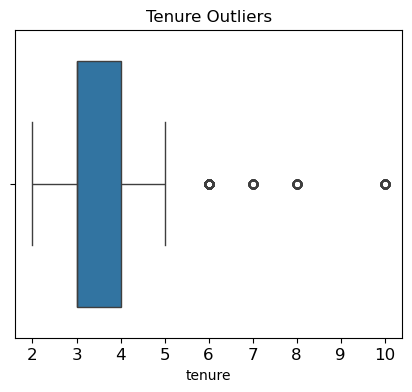

In [8]:
# Boxplot for checking outliers
plt.figure(figsize=(5, 4))
plt.title('Tenure Outliers', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['tenure'])
plt.show()

In [9]:
# finding number of tenure outlier rows
# (for considering model impacts of outliers)

# compute 25th and 75th percentile value in tenure
percentile25 = df["tenure"].quantile(0.25)
percentile75 = df["tenure"].quantile(0.75)

# compute interquartile range
iqr = percentile75 - percentile25

# compute upper and lower limit of non-outlier values
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit, "\n")

# compute list of outlier rows from dataframe
outliers = df[(df["tenure"] > upper_limit) | (df["tenure"] < lower_limit)]

# print number of outlier rows
print("Number of `tenure` outliers:", len(outliers))

Lower limit: 1.5
Upper limit: 5.5 

Number of `tenure` outliers: 824


In [10]:
# percentage of retained vs. churned employees
status_counts = df["left"].value_counts().values
percentage_left = (status_counts[1]) / (status_counts[0])
percentage_left
print("Percentage of retained employees:", 1 - percentage_left)
print("Percentage of churned employees:", percentage_left)

# class distribution (~80/20) is not ideal for modeling accuracy
# if the modeling goes poorly for that reason we can manipulate the distribution

Percentage of retained employees: 0.8009
Percentage of churned employees: 0.1991


In [11]:
# analyzing the data with some visualization

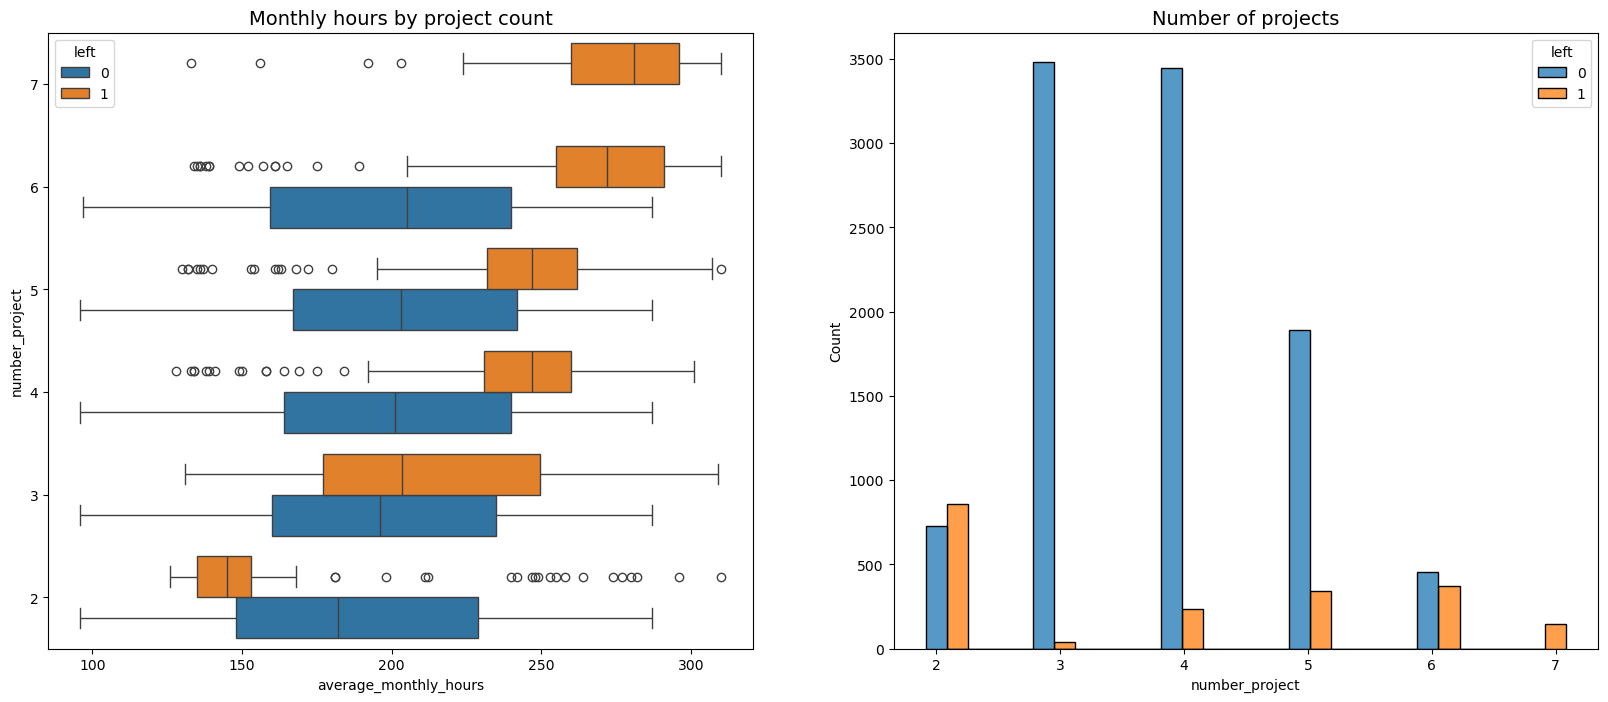

In [12]:
# set figure and axes
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# boxplot showing `average_monthly_hours` distributions for `number_project`
sns.boxplot(
    data=df,
    x="average_monthly_hours",
    y="number_project",
    hue="left",
    orient="h",
    ax=ax[0],
)
ax[0].invert_yaxis()
ax[0].set_title("Monthly hours by project count", fontsize="14")

# histogram showing distribution of `number_project`
tenure_stay = df[df["left"] == 0]["number_project"]
tenure_left = df[df["left"] == 1]["number_project"]
sns.histplot(
    data=df, x="number_project", hue="left", multiple="dodge", shrink=2, ax=ax[1]
)
ax[1].set_title("Number of projects", fontsize="14")

# display the plots
plt.show()

In [13]:
# 160 hours monthly (40 a week) is standard!

# we can see that non-standard counts of work projects correlates with leaving (including dismissals).
# plenty of likely co-factors there, but employees leaving from being overworked seems evident.

In [14]:
# value counts of stayed/left for employees with 7 projects
df[df['number_project'] == 7]['left'].value_counts()

left
1    145
Name: count, dtype: int64

In [15]:
# every employee who had 7 projects churned

Text(0.5, 1.0, 'Monthly hours by last evaluation score')

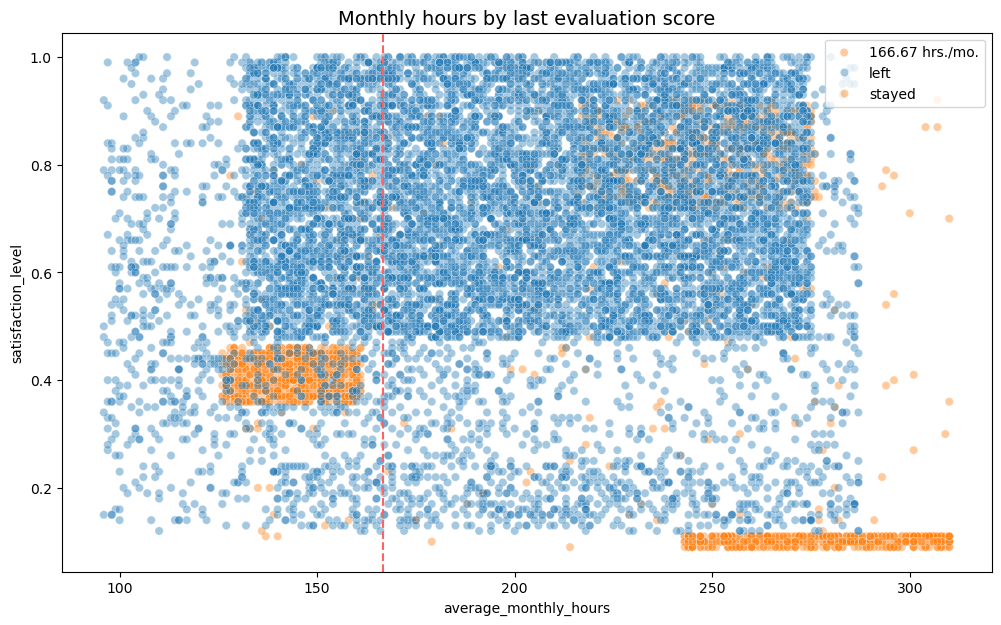

In [16]:
# scatterplot of `average_monthly_hours` vs. `satisfaction_level`
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df, x="average_monthly_hours", y="satisfaction_level", hue="left", alpha=0.4
)
plt.axvline(x=166.67, color="#ff6361", label="166.67 hrs./mo.", ls="--")
plt.legend(labels=["166.67 hrs./mo.", "left", "stayed"])
plt.title("Monthly hours by last evaluation score", fontsize="14")

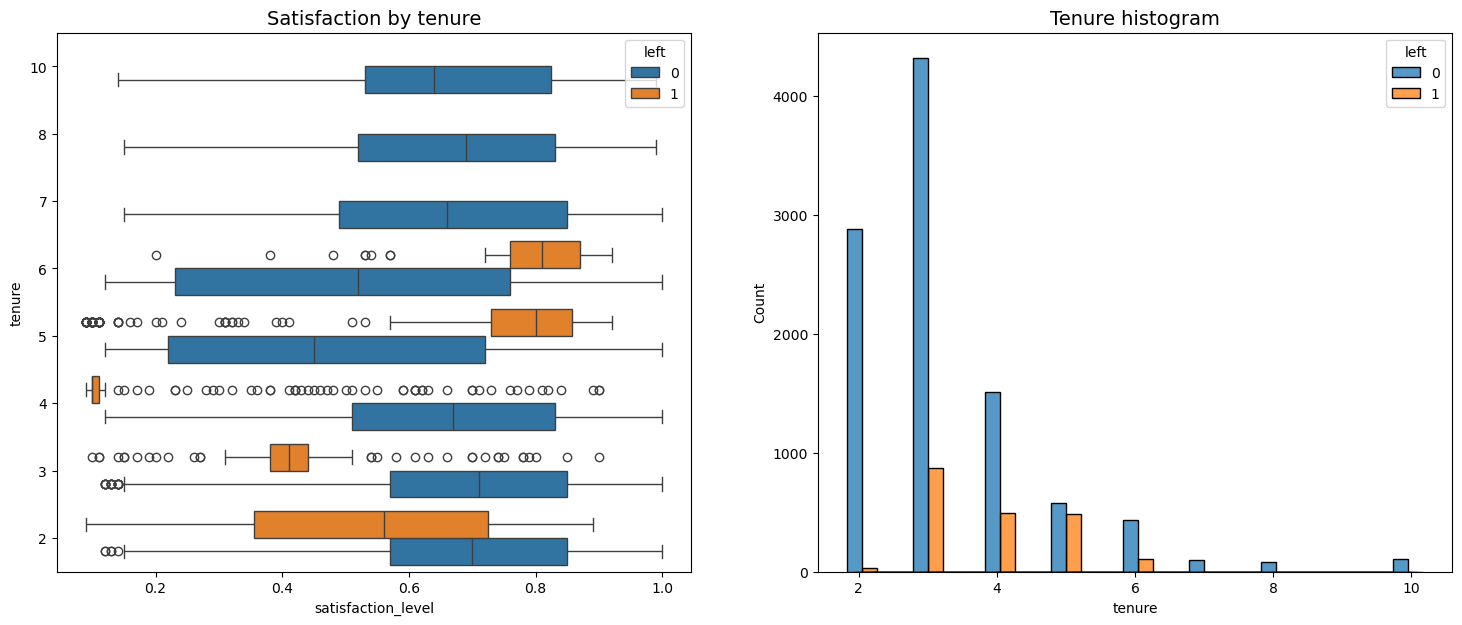

In [17]:
# set figure and axes
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# boxplot showing distributions of `satisfaction_level` by tenure
sns.boxplot(
    data=df, x="satisfaction_level", y="tenure", hue="left", orient="h", ax=ax[0]
)
ax[0].invert_yaxis()
ax[0].set_title("Satisfaction by tenure", fontsize="14")

# histogram showing distribution of tenure
tenure_stay = df[df["left"] == 0]["tenure"]
tenure_left = df[df["left"] == 1]["tenure"]
sns.histplot(data=df, x="tenure", hue="left", multiple="dodge", shrink=5, ax=ax[1])
ax[1].set_title("Tenure histogram", fontsize="14")

plt.show()

In [18]:
# mean and median satisfaction scores of churned vs. retained employees
df.groupby(['left'])['satisfaction_level'].agg(["mean", "median"])

,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


Text(0.5, 1.0, 'Monthly hours by promotion last 5 years')

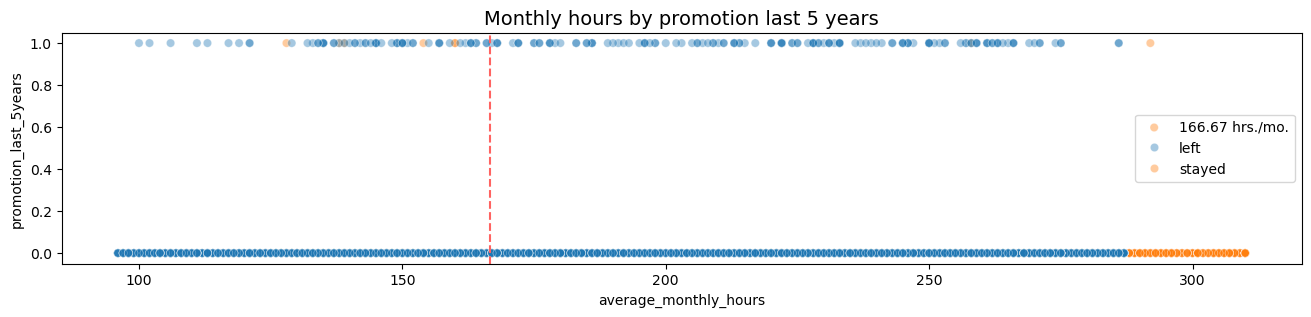

In [19]:
# plot to examine relationship between `average_monthly_hours` and `promotion_last_5years`
plt.figure(figsize=(16, 3))
sns.scatterplot(
    data=df, x="average_monthly_hours", y="promotion_last_5years", hue="left", alpha=0.4
)
plt.axvline(x=166.67, color="#ff6361", ls="--")
plt.legend(labels=["166.67 hrs./mo.", "left", "stayed"])
plt.title("Monthly hours by promotion last 5 years", fontsize="14")

In [20]:
# those who worked the most and weren't promoted in five years left.

In [21]:
# Display counts for each department
df["department"].value_counts()

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64

Text(0.5, 1.0, 'Counts of stayed/left by department')

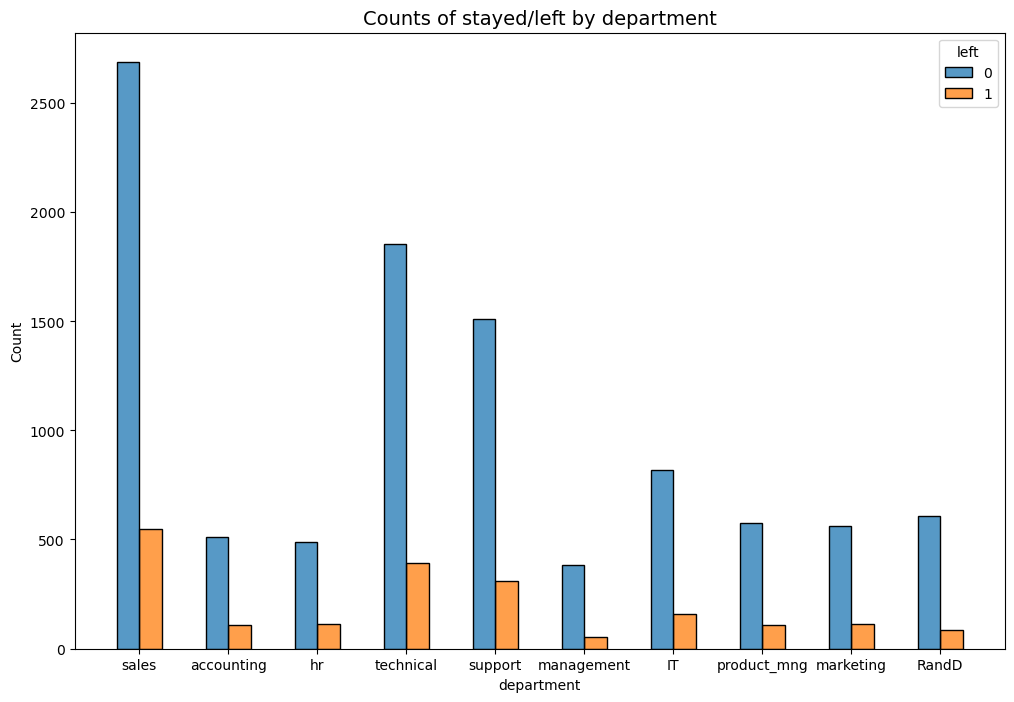

In [22]:
# histogram comparing department distribution of employees churned or retained
plt.figure(figsize=(12, 8))
sns.histplot(
    data=df,
    x="department",
    hue="left",
    discrete=1,
    hue_order=[0, 1],
    multiple="dodge",
    shrink=0.5,
)
plt.xticks(rotation="horizontal")
plt.title("Counts of stayed/left by department", fontsize=14)

Text(0.5, 1.0, 'Correlation Heatmap')

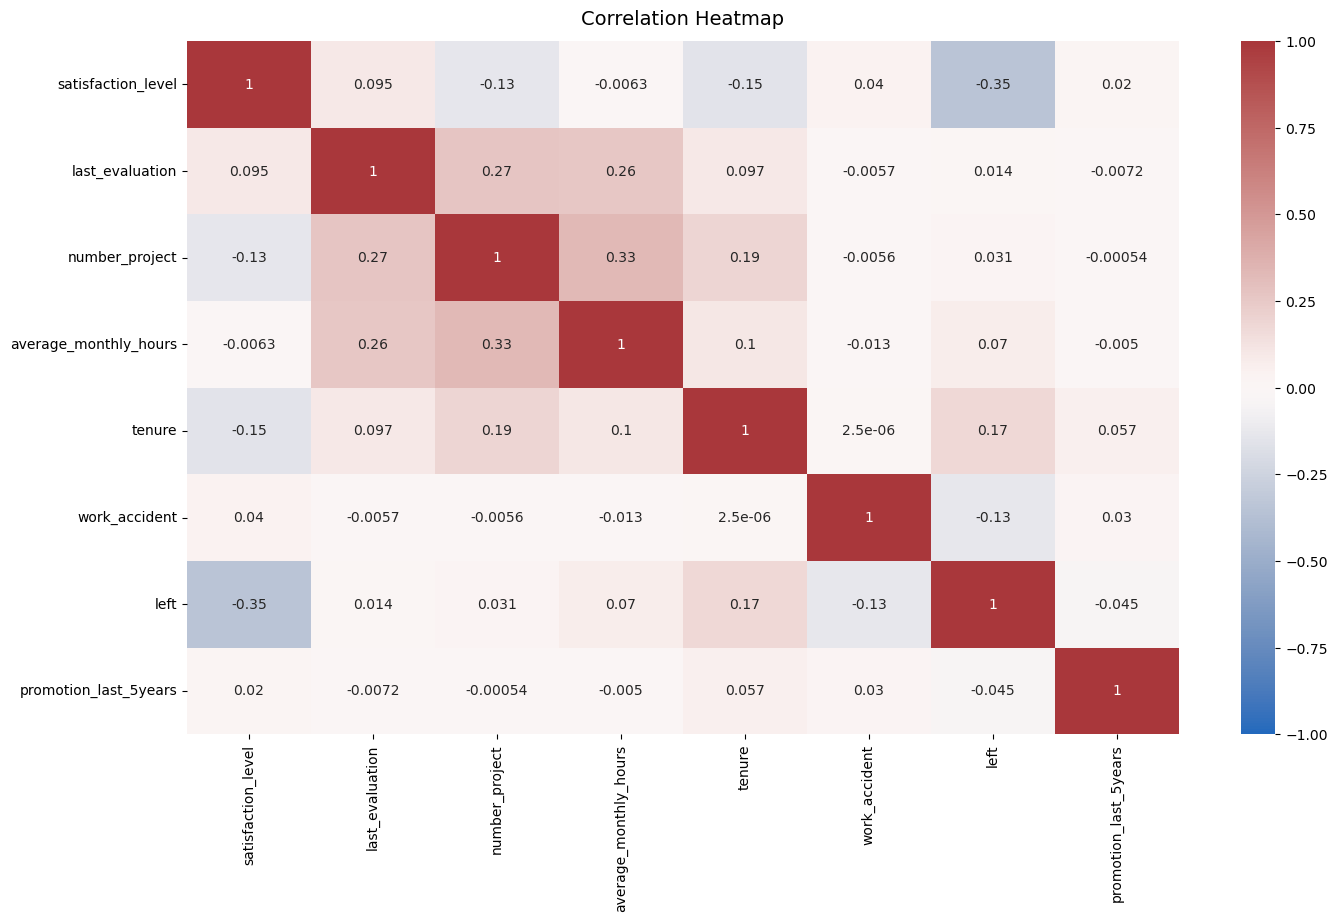

In [23]:
# correlation heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(
    df.corr(numeric_only=True),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap=sns.color_palette("vlag", as_cmap=True),
)
heatmap.set_title("Correlation Heatmap", fontdict={"fontsize": 14}, pad=12)

In [24]:
# there's a positive correlation between an employee's number of projects, hours, and evaluation scores,
# as well as a negative correlation between employee's satisfaction and leaving

## since the category "left", denoting churned or retained employees, is binary (0 and 1), we'll use logistic regression

In [25]:
# encode categorical variables, dummy encoding for department,
# and encoding 'salary' as an ordinal numeric category (0-2 for low, medium, and high) due to the hierarchy of salary

df_enc = df.copy()

df_enc["salary"] = (
    df_enc["salary"]
    .astype("category")
    .cat.set_categories(["low", "medium", "high"])
    .cat.codes
)

df_enc = pd.get_dummies(df_enc, drop_first=False)

df_enc.head(10)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
6,0.10,0.77,6,247,4,0,1,0,0,False,False,False,False,False,False,False,True,False,False
7,0.92,0.85,5,259,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
8,0.89,1.00,5,224,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
9,0.42,0.53,2,142,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [26]:
# remove those previous tenure outliers since logistic regression is sensitive to which
df_logreg = df_enc[
    (df_enc["tenure"] >= lower_limit) & (df_enc["tenure"] <= upper_limit)
]

df_logreg.head(10)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
6,0.10,0.77,6,247,4,0,1,0,0,False,False,False,False,False,False,False,True,False,False
7,0.92,0.85,5,259,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
8,0.89,1.00,5,224,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
9,0.42,0.53,2,142,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
10,0.45,0.54,2,135,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [27]:
# isolate outcome variable
y = df_logreg["left"]

# try using all features (columns) for the model
X = df_logreg.drop("left", axis=1)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# fit regression model
log_clf = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)

# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

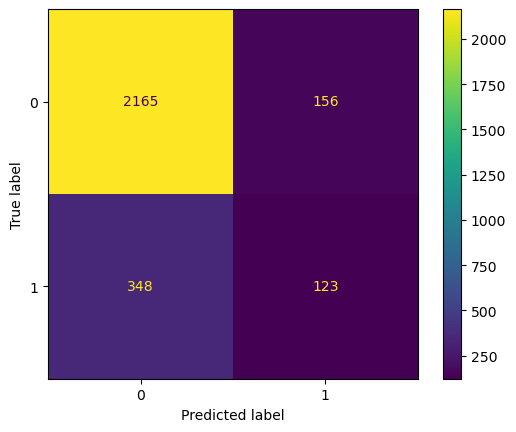

In [28]:
# compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# create display of confusion matrix
log_disp = ConfusionMatrixDisplay(
    confusion_matrix=log_cm, display_labels=log_clf.classes_
)

# plot confusion matrix
log_disp.plot(values_format="")

# display plot
plt.show()

In [29]:
# upper left is true negatives, upper right is false positives,
# bottom left is false negatives, bottom right is true positives

In [30]:
# classification report for model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.44      0.26      0.33       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.60      0.61      2792
             weighted avg       0.79      0.82      0.80      2792



In [31]:
# unfortunately the crucial predictions of employees leaving turned out pretty poor with our logistic regression model

## decision tree model

In [32]:
# isolate outcome variable
y = df_enc['left']

# select features
X = df_enc.drop('left', axis=1)

In [33]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    stratify=y, random_state=0)

In [34]:
# instantiate model
tree = DecisionTreeClassifier(random_state=0)

# assign dictionary of hyperparameters to search over
cv_params = {
    "max_depth": [4, 6, 8, None],
    "min_samples_leaf": [2, 5, 1],
    "min_samples_split": [2, 4, 6],
}

# assign a dictionary of scoring metrics to capture
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit="roc_auc")

In [35]:
%%time
tree1.fit(X_train, y_train)

CPU times: total: 3.11 s
Wall time: 3.03 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [36]:
# check best parameters
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [37]:
# check best AUC score on CV
tree1.best_score_

np.float64(0.969819392792457)

In [38]:
# near perfect score in determining between classes

In [39]:
def make_results(model_name: str, model_object, metric: str):
    """
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc

    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.
    """

    # create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {
        "auc": "mean_test_roc_auc",
        "precision": "mean_test_precision",
        "recall": "mean_test_recall",
        "f1": "mean_test_f1",
        "accuracy": "mean_test_accuracy",
    }

    # get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[
        cv_results[metric_dict[metric]].idxmax(), :
    ]

    # extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # create table of results
    table = pd.DataFrame()
    table = pd.DataFrame(
        {
            "model": [model_name],
            "precision": [precision],
            "recall": [recall],
            "F1": [f1],
            "accuracy": [accuracy],
            "auc": [auc],
        }
    )
    return table

In [40]:
# get all CV scores
tree1_cv_results = make_results("decision tree cv", tree1, "auc")
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.914552,0.916949,0.915707,0.971978,0.969819


In [41]:
# great performance!

## random forest model

In [42]:
# instantiate model
rf = RandomForestClassifier(random_state=0)

# assign a dictionary of hyperparameters to search over
cv_params = {
    "max_depth": [3, 5, None],
    "max_features": [1.0],
    "max_samples": [0.7, 1.0],
    "min_samples_leaf": [1, 2, 3],
    "min_samples_split": [2, 3, 4],
    "n_estimators": [300, 500],
}

# assign a dictionary of scoring metrics to capture
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit="roc_auc")

In [43]:
%%time
rf1.fit(X_train, y_train)

CPU times: total: 16min 3s
Wall time: 16min 14s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [44]:
# wall time was ~15mins for my system

In [45]:
# define a path to the folder where you want to save the model
path = '/users/galif/.jupyter/models/'

In [46]:
def write_pickle(path, model_object, save_as: str):
    """
    In:
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    """

    with open(path + save_as + ".pickle", "wb") as to_write:
        pickle.dump(model_object, to_write)

In [47]:
def read_pickle(path, saved_model_name: str):
    """
    In:
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out:
        model: the pickled model
    """
    with open(path + saved_model_name + ".pickle", "rb") as to_read:
        model = pickle.load(to_read)

    return model

In [48]:
# write pickle
write_pickle(path, rf1, 'hr_rf1')

# read pickle
rf1 = read_pickle(path, 'hr_rf1')

In [49]:
# check best AUC score on CV
rf1.best_score_

np.float64(0.9804250949807172)

In [50]:
# check best params
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 500}

In [51]:
# get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.950023  0.915614  0.932467  0.977983  0.980425


In [52]:
# the random tree model outperforms the decision tree

In [53]:
# get all scores of a model's predictions
def get_scores(model_name: str, model, X_test_data, y_test_data):
    """
    Generate a table of test scores.

    In:
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    """

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame(
        {
            "model": [model_name],
            "precision": [precision],
            "recall": [recall],
            "f1": [f1],
            "accuracy": [accuracy],
            "AUC": [auc],
        }
    )

    return table

In [54]:
# get predictions on test data
rf1_test_scores = get_scores("random forest1 test", rf1, X_test, y_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.964211,0.919679,0.941418,0.980987,0.956439


In [55]:
# model's performance on unseen test data

## practicing feature engineering and avoiding potential data leakage

In [56]:
# drop `satisfaction_level` and save resulting dataframe in new variable
df2 = df_enc.drop('satisfaction_level', axis=1)

# make new `overworked` column.
df2['overworked'] = df2['average_monthly_hours']

# max and min average monthly hours values
print('Max hours:', df2['overworked'].max())
print('Min hours:', df2['overworked'].min())

Max hours: 310
Min hours: 96


In [57]:
# define `overworked` as working > 175 hrs/week using a boolean mask on the column
df2['overworked'] = (df2['overworked'] > 175).astype(int)

# display first few rows of new column
df2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

In [58]:
# drop the `average_monthly_hours` column, antiquated
df2 = df2.drop('average_monthly_hours', axis=1)

df2.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0
1,0.86,5,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
2,0.88,7,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
3,0.87,5,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False,1
4,0.52,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0


In [59]:
# isolate the outcome variable
y = df2["left"]

# select the features
X = df2.drop("left", axis=1)

# create test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=0
)

In [60]:
# instantiate model
tree = DecisionTreeClassifier(random_state=0)

# assign a dictionary of hyperparameters to search over
cv_params = {
    "max_depth": [4, 6, 8, None],
    "min_samples_leaf": [2, 5, 1],
    "min_samples_split": [2, 4, 6],
}

# assign a dictionary of scoring metrics to capture
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# instantiate GridSearch
tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit="roc_auc")

In [61]:
%%time
tree2.fit(X_train, y_train)

CPU times: total: 2.86 s
Wall time: 2.65 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [62]:
# check best params
tree2.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [63]:
# check best AUC score on CV
tree2.best_score_

np.float64(0.9586752505340426)

In [64]:
# get all CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675


Some of the other scores fell. That's to be expected given fewer features were taken into account in this round of the model. Still, the scores are very good.

In [65]:
# performs worse to the original understandably, still quite good

## round 2 of random forest

In [66]:
# instantiate model
rf = RandomForestClassifier(random_state=0)

# assign a dictionary of hyperparameters to search over
cv_params = {
    "max_depth": [3, 5, None],
    "max_features": [1.0],
    "max_samples": [0.7, 1.0],
    "min_samples_leaf": [1, 2, 3],
    "min_samples_split": [2, 3, 4],
    "n_estimators": [300, 500],
}

# assign a dictionary of scoring metrics to capture
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# instantiate GridSearch
rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit="roc_auc")

In [67]:
%%time
rf2.fit(X_train, y_train)

CPU times: total: 11min 59s
Wall time: 12min 12s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [68]:
# wall time was ~12mins for my system

In [69]:
# write pickle
write_pickle(path, rf2, "hr_rf2")

# read in pickle
rf2 = read_pickle(path, "hr_rf2")

In [70]:
# check best params
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [71]:
# check best AUC score on CV
rf2.best_score_

np.float64(0.9648100662833985)

In [72]:
# get all CV scores
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675
               model  precision    recall        F1  accuracy      auc
0  random forest2 cv   0.866758  0.878754  0.872407  0.957411  0.96481


In [73]:
# scores are still worse after experimenting, but the rf still edges out the decision tree

In [74]:
# get predictions on test data
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest2 test,0.870406,0.903614,0.8867,0.961641,0.938407


In [75]:
# test data performance is great

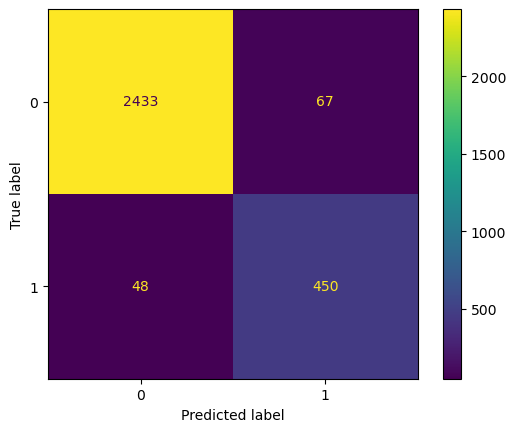

In [76]:
# generate array of values for confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf2.classes_)
disp.plot(values_format="")

In [77]:
# biggest drawback to an otherwise great model is its false positives, so its a little jumpy to predict someone leaving

In [78]:
# get the decision tree's feature importance
tree2_importances = pd.DataFrame(
    tree2.best_estimator_.feature_importances_,
    columns=["gini_importance"],
    index=X.columns,
)
tree2_importances = tree2_importances.sort_values(by="gini_importance", ascending=False)

# only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances["gini_importance"] != 0]
tree2_importances

,gini_importance
last_evaluation,0.343958
number_project,0.343385
tenure,0.215681
overworked,0.093498
department_support,0.001142
salary,0.000910
department_sales,0.000607
department_technical,0.000418
work_accident,0.000183
department_IT,0.000139


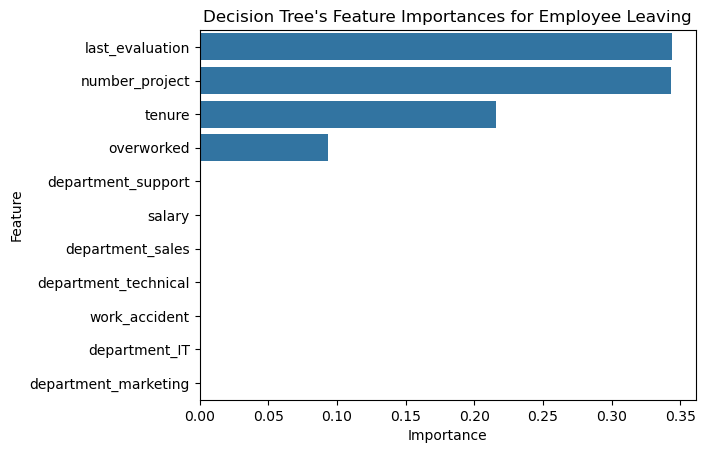

In [79]:
# now graph that
sns.barplot(
    data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient="h"
)
plt.title("Decision Tree's Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

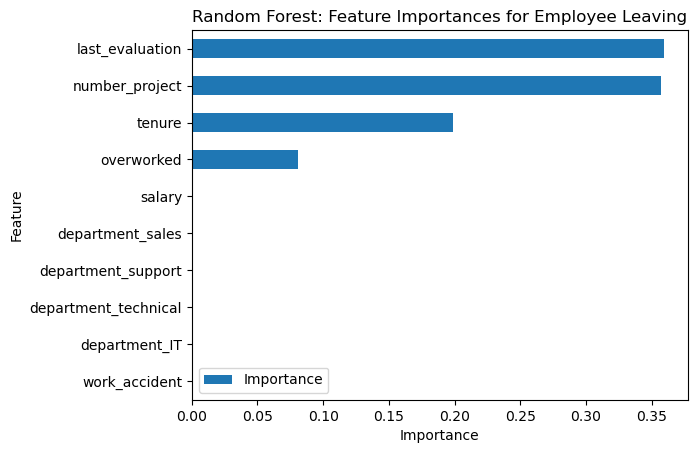

In [80]:
# get random forest feature importances
feat_impt = rf2.best_estimator_.feature_importances_

# get indices of top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

# get column labels of top 10 features
feat = X.columns[ind]

# filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature": feat, "Importance": feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind="barh", ax=ax1, x="Feature", y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

In [81]:
# both decision tree and random forest models seem to have the same feature importances